In [1]:
from f_drosophila_infer import *
from f_train import *
from f_data_prep import *
from sklearn import linear_model

In [2]:
data_all = np.loadtxt('../data_complete.txt')
median = np.median(data_all, axis=0)
# data_all = data_all - median
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_init = np.vstack([comp_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

all_init, all_diff = shuffle(all_init, all_diff)
comp_init, comp_diff = shuffle(comp_init, comp_diff)

In [3]:
def LAD_cv_quad_cellselect(X, y, gene_comp=comp_ind, kf=10, p=3):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    w_list = []
    bias_list = []
    ya_list = []
    yp_list = []
    
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (cell_in, cell_ex) in (kfold.split(range(6078))):
        te = np.hstack([cell_ex+(6078*i) for i in range(5)])
        tr = np.delete(range(30390), te)
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        if y.shape[1] == len(gene_comp):
            X_init = np.copy(X_te[:, comp_ind])
        else:
            X_init = np.copy(X_te)
        
        y_actual = X_init + y_te
        ya_list.append(y_actual)
        
        w,bias = infer_LAD_p(quad_tr, y_tr, p)
        w_list.append(w)
        bias_list.append(bias)
            
        y_pred = X_init + (bias + quad_te.dot(w))
        yp_list.append(y_pred)
    
    dic = {
        'w': w_list,
        'bias': bias_list,
        'y_actual': ya_list,
        'y_pred': yp_list
    }
        
    return dic

def skl_cv_quad_cellselect(X, y, gene_comp=comp_ind, kf=10):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    ferror_list=[]
    error_list_gene = []
    error_list_cell = []
    error2_list_cell = []
    coef = []
    intercept = []
    ya_list = []
    yp_list = []
    
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (cell_in, cell_ex) in (kfold.split(range(6078))):
        te = np.hstack([cell_ex+(6078*i) for i in range(5)])
        tr = np.delete(range(30390), te)
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        if y.shape[1] == len(gene_comp):
            X_init = np.copy(X_te[:, comp_ind])
        else:
            X_init = np.copy(X_te)
        
        y_actual = X_init + y_te
        ya_list.append(y_actual)
        
        y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        
        regr = linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        y_pred = X_init + regr.predict(quad_te)
        yp_list.append(y_pred)
        
        coef.append(regr.coef_)
        intercept.append(regr.intercept_)
        
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
        ferror_list.append(error)
        
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0))**(1/2)
        error_list_gene.append(error)
        
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=1))**(1/2)
        error_list_cell.append(error)
        
        error = np.sum(np.abs(y_pred - y_actual), axis=1)
        error2_list_cell.append(error)
    
    dic = {
        'ferror': ferror_list,
        'error_gene': error_list_gene,
        'error_cell_l2': error_list_cell,
        'error_cell_l1': error2_list_cell,
        'w': coef,
        'bias': intercept,
        'y_actual': ya_list,
        'y_pred': yp_list
    }
        
    return dic

In [4]:
# for i in range(1,5):
#     LAD_quad_cellselect = LAD_cv_quad_cellselect(all_init, all_diff, gene_comp=comp_ind, kf=10, p=i)
#     with open('./pickles/LAD_%s_quad_cellselect.pkl' %i, 'wb') as f:
#         pickle.dump(LAD_quad_cellselect, f)

In [5]:
# skl_quad_cellselect = skl_cv_quad_cellselect(all_init, all_diff, gene_comp=comp_ind, kf=10)
# with open('./pickles/skl_quad_cellselect.pkl', 'wb') as f:
#     pickle.dump(skl_quad_cellselect, f)

In [6]:
# import seaborn as sns
# with open('./pickles/skl_quad_cellselect.pkl', 'rb') as f:
#         skl_quad = pickle.load(f)
# for i in range(1,5):
#     with open('./pickles/LAD_%s_quad_cellselect.pkl' %i, 'rb') as f:
#         LAD_quad = pickle.load(f)
#     delta = [np.abs(LAD_quad['y_actual'][j] - LAD_quad['y_pred'][j]) for j in range(10)]
#     error_LAD = [np.sum((delta[j]**(i-2)/sperf(delta[j])**(i-2))*delta[j]**2, axis=1)**(1/i) for j in range(10)]
    
#     delta = [np.abs(skl_quad['y_actual'][j] - skl_quad['y_pred'][j]) for j in range(10)]
#     error_skl = [np.sum((delta[j]**(i-2)/sperf(delta[j])**(i-2))*delta[j]**2, axis=1)**(1/i) for j in range(10)]
    
#     plt.figure(figsize=(8,6))
#     sns.distplot(np.hstack(error_LAD), bins=100, label='LAD')
#     sns.distplot(np.hstack(error_skl), bins=100, label='skl')
#     plt.legend(bbox_to_anchor=(1,0.5))
#     plt.title('absolute error (L-%s norm)' %i)
#     plt.show()

### $\left[\sum\left[\dfrac{\Delta^{i-2}}{erf(\Delta)^{i-2}}\right]\Delta^{2}\right]^{1/i}$, $\Delta = \left| y - b+x.W \right|$

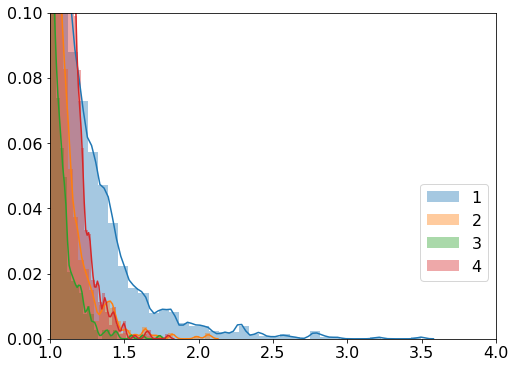

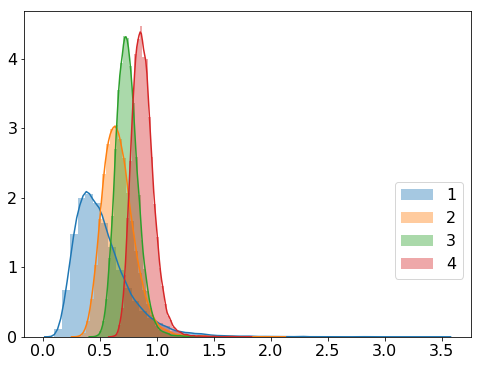

In [7]:
import seaborn as sns
plt.figure(figsize=(8,6))

for i in range(1,5):
    with open('./pickles/LAD_%s_quad_cellselect.pkl' %i, 'rb') as f:
        LAD_quad = pickle.load(f)
    delta = [np.abs(LAD_quad['y_actual'][j] - LAD_quad['y_pred'][j]) for j in range(10)]
    error_LAD = [np.sum((delta[j]/sperf(delta[j]))**(i-2)*delta[j]**2, axis=1)**(1/i) for j in range(10)]
    sns.distplot(np.hstack(error_LAD), label=('%s' %i))
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.ylim(0,0.1)
    plt.xlim(1,4)
    
plt.figure(figsize=(8,6))

for i in range(1,5):
    with open('./pickles/LAD_%s_quad_cellselect.pkl' %i, 'rb') as f:
        LAD_quad = pickle.load(f)
    delta = [np.abs(LAD_quad['y_actual'][j] - LAD_quad['y_pred'][j]) for j in range(10)]
    error_LAD = [np.sum((delta[j]**(i-2)/sperf(delta[j])**(i-2))*delta[j]**2, axis=1)**(1/i) for j in range(10)]
    sns.distplot(np.hstack(error_LAD), label=('%s' %i))
    plt.legend(bbox_to_anchor=(1,0.5))
plt.show()

In [8]:
# fig = plt.figure(figsize=(8,12))
# ax1=fig.add_subplot(2,1,1)
# sns.distplot(np.hstack(LAD_quad[2]), bins=100, label='LAD')
# sns.distplot(np.hstack(skl_quad[3]), bins=100, label='skl')
# ax1.legend(bbox_to_anchor=(1,0.5))
# ax1.set_title('absolute error (L-1 norm)')
# ax2=fig.add_subplot(2,1,2)
# sns.distplot(np.hstack(LAD_quad[3]), bins=100, label='LAD')
# sns.distplot(np.hstack(skl_quad[2]), bins=100, label='skl')
# ax2.legend(bbox_to_anchor=(1,0.5))
# ax2.set_title('absolute error (L-2 norm)')
# # plt.show()
# plt.savefig('LAD vs. skl cell_ex.pdf')

### $\left(\sum\Delta^{i}\right)^{1/i}$, $\Delta = \left| y - b+x.W \right|$

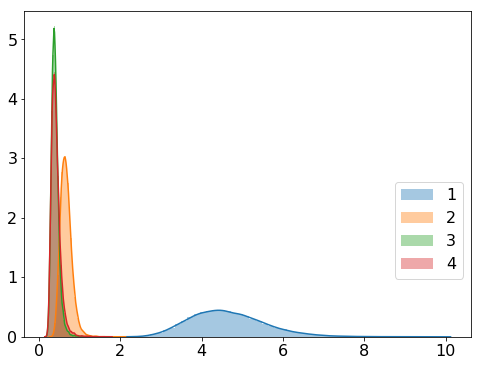

In [9]:
plt.figure(figsize=(8,6))

for i in range(1,5):
    with open('./pickles/LAD_%s_quad_cellselect.pkl' %i, 'rb') as f:
        LAD_quad = pickle.load(f)
    delta = [np.abs(LAD_quad['y_actual'][j] - LAD_quad['y_pred'][j]) for j in range(10)]
    error_LAD = [np.sum(delta[j]**i, axis=1)**(1/i) for j in range(10)]
    sns.distplot(np.hstack(error_LAD), label=('%s' %i))
    plt.legend(bbox_to_anchor=(1,0.5))
#     plt.ylim(0,0.1)
#     plt.xlim(1,4)
    
# plt.figure(figsize=(8,6))

# for i in range(1,5):
#     with open('./pickles/LAD_%s_quad_cellselect.pkl' %i, 'rb') as f:
#         LAD_quad = pickle.load(f)
#     delta = [np.abs(LAD_quad['y_actual'][j] - LAD_quad['y_pred'][j]) for j in range(10)]
#     error_LAD = [np.sum(delta[j]**i, axis=1)**(1/i) for j in range(10)]
#     sns.distplot(np.hstack(error_LAD), label=('%s' %i))
#     plt.legend(bbox_to_anchor=(1,0.5))
# plt.show()

In [10]:
# q = np.array([2,5,10])
# for i in q:
#     LAD_quad_cellselect = LAD_cv_quad_cellselect(all_init, all_diff, gene_comp=comp_ind, kf=10, p=1/i)
#     with open('./pickles/LAD_1over%s_quad_cellselect.pkl' %i, 'wb') as f:
#         pickle.dump(LAD_quad_cellselect, f)

In [11]:
# import os
# for file in os.listdir(path='./pickles'):
#     if file.endswith('quad_cellselect.pkl') and file.startswith('LAD') and file[4].isdigit():
#         print(file)
#         with open('./pickles/'+file, 'rb') as f:
#             l = pickle.load(f)
            

### $\left(\sum\Delta^{i}\right)^{1/i}$, $\Delta = \left| y - b+x.W \right|$

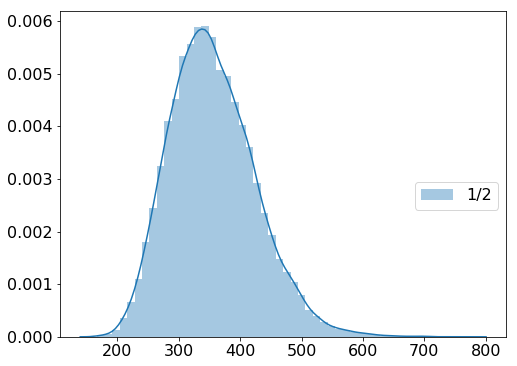

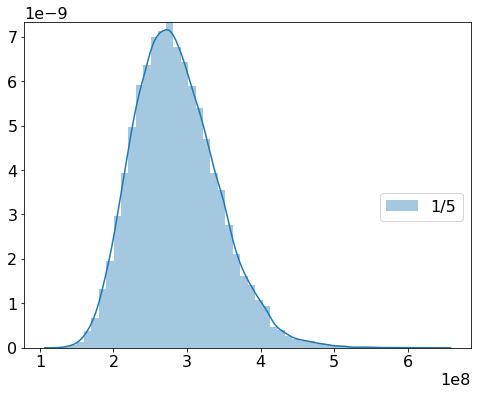

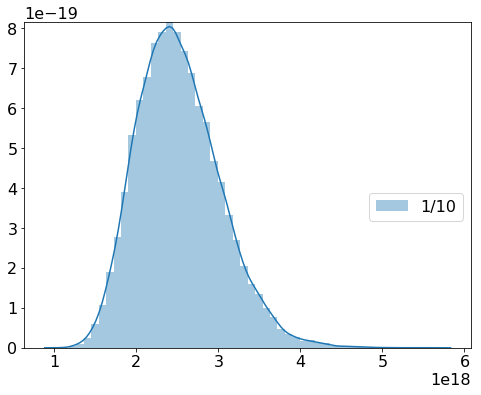

In [12]:
for i in np.array([2,5,10]):
    plt.figure(figsize=(8,6))
    with open('./pickles/LAD_1over%s_quad_cellselect.pkl' %i, 'rb') as f:
        LAD_quad = pickle.load(f)
    delta = [np.abs(LAD_quad['y_actual'][j] - LAD_quad['y_pred'][j]) for j in range(10)]
    error_LAD = [np.sum(delta[j]**(1/i), axis=1)**(i) for j in range(10)]
    sns.distplot(np.hstack(error_LAD), label=('1/%s' %i))
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.show()

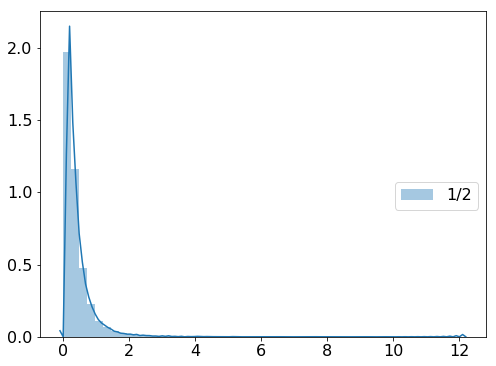

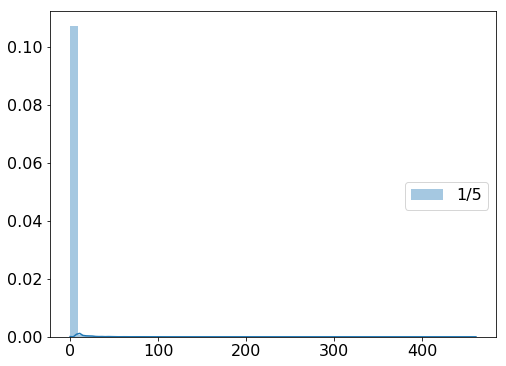

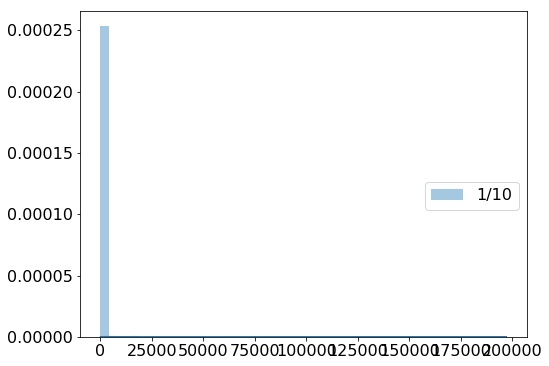

In [13]:
for i in np.array([2,5,10]):
    plt.figure(figsize=(8,6))
    with open('./pickles/LAD_1over%s_quad_cellselect.pkl' %i, 'rb') as f:
        LAD_quad = pickle.load(f)
    delta = [np.abs(LAD_quad['y_actual'][j] - LAD_quad['y_pred'][j]) for j in range(10)]
    error_LAD = [np.sum((delta[j]/sperf(delta[j]))**(1/i-2)*delta[j]**2, axis=1)**(i) for j in range(10)]
    sns.distplot(np.hstack(error_LAD), label=('1/%s' %i))
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.show()
